# Normalization method
* The models were trained with data instance min-max normalized, each training sample was scaled according to its min and max 
* This version will also normalize each inference data sample with its min and max
* The output of the GAN will be then de-normalized with the min and max of the input 

In [2]:
import h5py
import torch
import torch.nn as nn
import random


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
from scipy.io import savemat
from torch.utils.data import DataLoader, TensorDataset

sys.path.append('../../helper')
import loader
import utils

sys.path.append('../../train/Pix2Pix/helperPix2Pix')
from generator_model import Generator
from discriminator_model import Discriminator

In [9]:
rowss = '3500_3516'
model_path = '../../model/static/GAN/BS16/'+ rowss + '/ver17_/'
CDL_path = '../../../CDL Customization/Data/ver39_/'
epoch = 20
SNR = np.arange(-25, 31, 5) # -25:5:30 dB
device = 'cpu'
BATCH_SIZE = 32

# Min-max Scaler to [-1 1] range
norm_approach = 'minmax'
lower_range = -1

average_nmse_LS_LI = []     # with length same as length of SNR 
average_nmse_LI_GAN = []
average_nmse_LS_GAN = []


for snr in SNR:
    # variables = torch.load(model_path + str(snr) + 'dB/CNN_1_variable.pth')

    gan_LS_G = Generator()
    gan_LS_D = Discriminator()
    checkpoint_LS_G = torch.load(model_path + str(snr) + 'dB/' + str(epoch) + 'epoc_G_1_LS_GAN_model.pth')
    checkpoint_LS_D = torch.load(model_path + str(snr) + 'dB/' + str(epoch) + 'epoc_D_1_LS_GAN_model.pth')
    
    gan_LS_G.load_state_dict(checkpoint_LS_G['model_state_dict'])
    gan_LS_D.load_state_dict(checkpoint_LS_D['model_state_dict'])
    gan_LS_G.eval()
    gan_LS_D.eval()

    
    gan_LI_G = Generator()
    gan_LI_D = Discriminator()
    checkpoint_LI_G = torch.load(model_path + str(snr) + 'dB/G_1_LS_LI_GAN_model.pth')
    checkpoint_LI_D = torch.load(model_path + str(snr) + 'dB/D_1_LS_LI_GAN_model.pth')
    gan_LI_G.load_state_dict(checkpoint_LI_G['model_state_dict'])
    gan_LI_D.load_state_dict(checkpoint_LI_D['model_state_dict'])
    gan_LI_G.eval()
    gan_LI_D.eval()

    mapBaseData_path = CDL_path + str(snr) + 'dB/1_mapBaseData.mat'
    file = h5py.File(mapBaseData_path, 'r')
    file['H_data'].shape

    H_true = np.empty((0, 2, 612, 14)) # true channel
    H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
    H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
            
    H_true = np.concatenate((H_true, (np.array(file['H_data']))) , axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, (np.array(file['H_equalized_data']))), axis = 0)
    H_linear = np.concatenate((H_linear, (np.array(file['H_linear_data']))), axis=0)

    H_true = torch.from_numpy(H_true)
    H_equal = torch.from_numpy(H_equal)
    H_linear = torch.from_numpy(H_linear)
    
    testData_LS_normd, test_LS_min, test_LS_max = utils.minmaxScaler(H_equal)
    testData_LI_normd, test_LI_min, test_LI_max = utils.minmaxScaler(H_linear)
    
    min_maxLS = torch.stack((test_LS_min, test_LS_max), dim=1)
    min_maxLI = torch.stack((test_LI_min, test_LI_max), dim=1)

    testData_LS_normd = testData_LS_normd.to(device, dtype=torch.float)
    testData_LI_normd = testData_LI_normd.to(device, dtype=torch.float)
    min_maxLS         = min_maxLS.to(device, dtype=torch.float)
    min_maxLI         = min_maxLI.to(device, dtype=torch.float)
                                        
    
    H_true = H_true.to(device, dtype=torch.float)

    # Create a DataLoader for dataset
    test_dataset = TensorDataset(testData_LS_normd, testData_LI_normd, min_maxLS, min_maxLI, H_true)  # [nSamples, 2, 612, 14]
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)   


    with torch.no_grad():
        nmse_LS_LI_SNRi = []    # temp variable to save nmse of batchs of snr_i
        nmse_LS_NN_SNRi = []    # length is same as number of batches
        nmse_LI_NN_SNRi = []
        print(f"SNR: {snr}/{SNR[-1]}")
        for batch_idx, (LS_inputs, LI_inputs, minmaxLS, minmaxLI, test_targets) in enumerate(test_loader):
            # LS_inputs == channel after LS, after normalized
            # LI_inputs == channel after LS+LI, after normalized
            # test_targets == true channel
            if (batch_idx + 1)%5==0:
                print(f" - Batch {batch_idx + 1}/{len(test_loader)}")
            
            LS_inputs_real = LS_inputs[:,0,:,:].unsqueeze(1)
            LS_inputs_imag = LS_inputs[:,1,:,:].unsqueeze(1)
            
            LI_inputs_real = LI_inputs[:,0,:,:].unsqueeze(1)
            LI_inputs_imag = LI_inputs[:,1,:,:].unsqueeze(1)
            
            # 
            test_targets_complex = torch.complex(test_targets[:,0,:,:], test_targets[:,1,:,:])
            
        ##### NMSE of LS+NN
            LS_NN_outputs_real = gan_LS_G(LS_inputs_real) # 32x1x612x14
            LS_NN_outputs_imag = gan_LS_G(LS_inputs_imag) 
            LS_NN_outputs = torch.cat((LS_NN_outputs_real, LS_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LS_NN_outputs_denormd = utils.deMinMax(LS_NN_outputs, minmaxLS[:,0], minmaxLS[:,1])
            LS_NN_outputs_complex = torch.complex(LS_NN_outputs_denormd[:,0,:,:], LS_NN_outputs_denormd[:,1,:,:]) # 32x612x14
            # Calculate nmse
            nmse_LS_NN = utils.calNMSE(LS_NN_outputs_complex, test_targets_complex) # size=32 (batch_size)
            nmse_LS_NN_SNRi.append(nmse_LS_NN.cpu().mean())
            
        ##### NMSE of LS+LI
            # De-normalized --> return H_linear back 
            LS_LI_outputs_denormd = utils.deMinMax(LI_inputs, minmaxLI[:,0], minmaxLI[:,1])
            LS_LI_outputs_complex = torch.complex(LS_LI_outputs_denormd[:,0,:,:], LS_LI_outputs_denormd[:,1,:,:])
            # Calculate the nmse
            nmse_LS_LI = utils.calNMSE(LS_LI_outputs_complex, test_targets_complex) # size=32 (batch_size)
            nmse_LS_LI_SNRi.append(nmse_LS_LI.cpu().mean())
            
        ##### NMSE of LS+LI+NN
            LI_NN_outputs_real = gan_LI_G(LI_inputs_real)    # 32x1x612x14
            LI_NN_outputs_imag = gan_LI_G(LI_inputs_imag)
            LI_NN_outputs = torch.cat((LI_NN_outputs_real, LI_NN_outputs_imag), dim=1) # 32x2x612x14
            # De-normalized
            LI_NN_outputs_denormd = utils.deMinMax(LI_NN_outputs, minmaxLI[:,0], minmaxLI[:,1])
            LI_NN_outputs_complex = torch.complex(LI_NN_outputs_denormd[:,0,:,:], LI_NN_outputs_denormd[:,1,:,:])
            
            nmse_LI_NN = utils.calNMSE(LI_NN_outputs_complex, test_targets_complex) # size=32 (batch_size)
            nmse_LI_NN_SNRi.append(nmse_LI_NN.cpu().mean())
            
            
        average_nmse_LS_LI.append(sum(nmse_LS_LI_SNRi)/len(nmse_LS_LI_SNRi))
        average_nmse_LS_GAN.append(sum(nmse_LS_NN_SNRi)/len(nmse_LS_NN_SNRi))
        average_nmse_LI_GAN.append(sum(nmse_LI_NN_SNRi)/len(nmse_LI_NN_SNRi))

SNR: -25/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: -20/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: -15/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: -10/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: -5/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: 0/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: 5/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: 10/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: 15/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/32
SNR: 20/30
 - Batch 5/32
 - Batch 10/32
 - Batch 15/32
 - Batch 20/32
 - Batch 25/32
 - Batch 30/3

# Results

## True Channel

In [10]:
LS_NN_outputs_denormd.shape

torch.Size([8, 2, 612, 14])

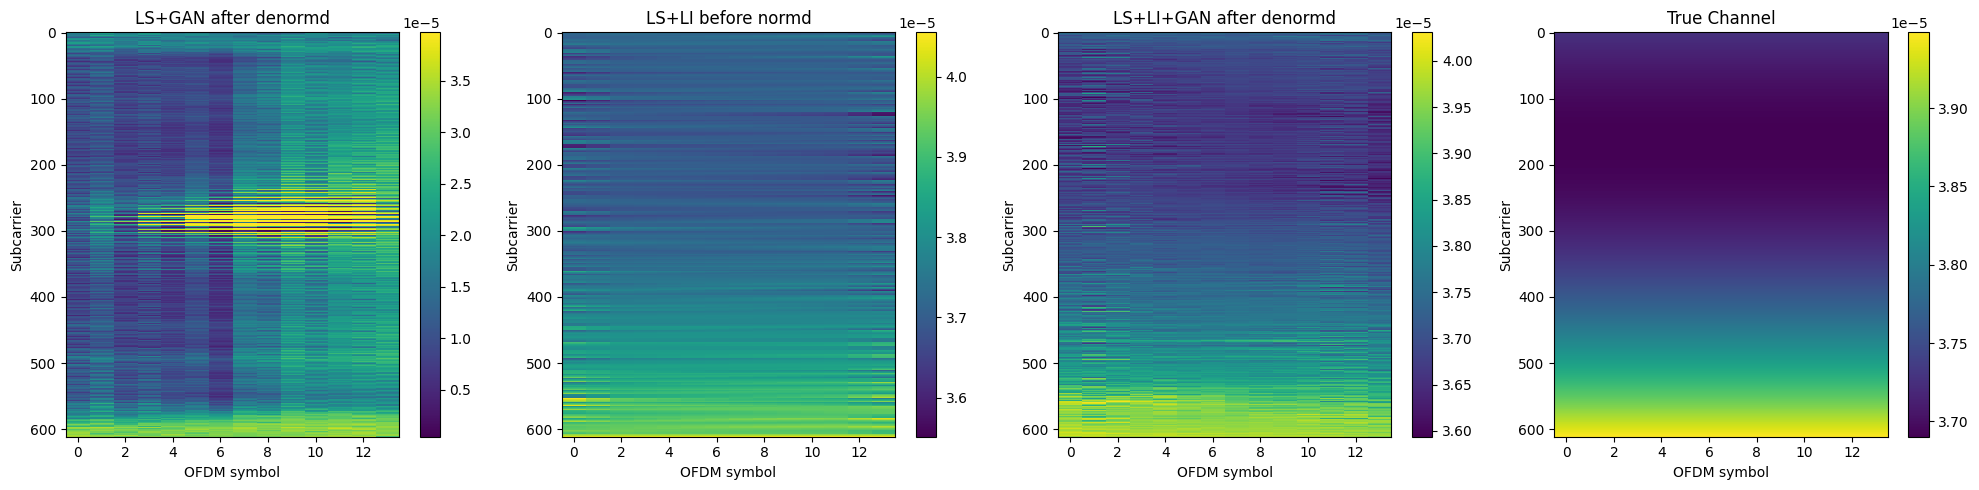

In [14]:
plt.figure(figsize=(20, 5))

plt.subplot(1,4,1)
plt.imshow(LS_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+GAN')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(H_linear[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(	LI_NN_outputs_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('LS+LI+GAN')
plt.colorbar()

plt.subplot(1,4,4)
plt.imshow(H_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title('True Channel')
plt.colorbar()

plt.tight_layout()
plt.show()

## NMSE

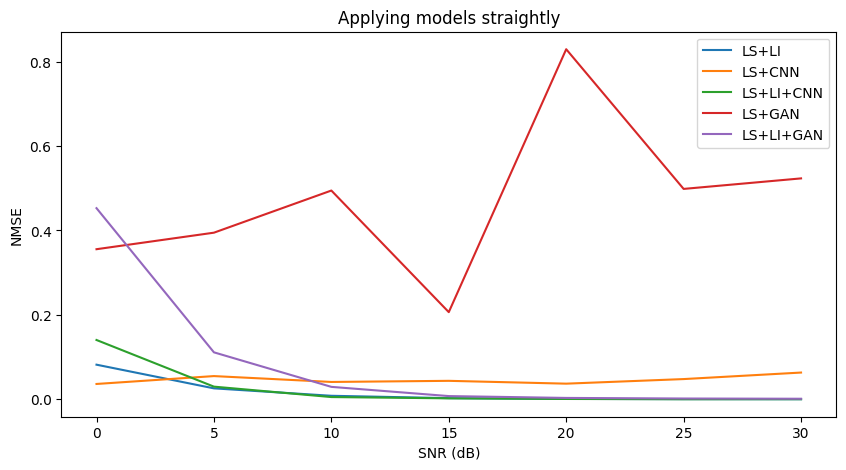

In [39]:
CNN_data = loadmat('../v6_/NMSE.mat')
average_nmse_LS_CNN_25_5 = CNN_data['nmse_LS_NN']
average_nmse_LI_CNN_25_5 = CNN_data['nmse_LI_NN']

CNN_data = loadmat('../v5_fig/NMSE.mat')
average_nmse_LS_CNN_0_30 = CNN_data['nmse_LS_NN']
average_nmse_LI_CNN_0_30 = CNN_data['nmse_LI_NN']

average_nmse_LS_CNN = np.concatenate((average_nmse_LS_CNN_25_5, average_nmse_LS_CNN_0_30), axis=1).reshape(12, 1)
average_nmse_LI_CNN = np.concatenate((average_nmse_LI_CNN_25_5, average_nmse_LI_CNN_0_30), axis=1).reshape(12, 1)

i = 5
j = 12

# GAN_data = loadmat('v1_/NMSE.mat')
# average_nmse_LS_GAN = GAN_data['nmse_LS_GAN']
# average_nmse_LI_GAN = GAN_data['nmse_LI_GAN']

plt.figure(figsize=(10, 5))
plt.plot(SNR[i:j], average_nmse_LS_LI[i:j], label = 'LS+LI')
plt.plot(SNR[i:j], average_nmse_LS_CNN[i:j], label = 'LS+CNN')
plt.plot(SNR[i:j], average_nmse_LI_CNN[i:j], label = 'LS+LI+CNN')
plt.plot(SNR[i:j], average_nmse_LS_GAN[i:j], label = 'LS+GAN')
plt.plot(SNR[i:j], average_nmse_LI_GAN[i:j], label = 'LS+LI+GAN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Applying models straightly')
plt.xticks(SNR[i:j])
plt.legend()
plt.savefig('v1_/NMSE.png')
plt.show()



In [12]:

index_save = loader.find_incremental_filename('../Pix2Pix', 'v', '_', '')
save_path = '../Pix2Pix/v'+str(index_save)+'_/NMSE.mat'

if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))

savemat(save_path, {'nmse_LS_LI':average_nmse_LS_LI, 'nmse_LS_GAN':average_nmse_LS_GAN, 'nmse_LI_GAN': average_nmse_LI_GAN})

# create readme.txt file
content = f"""Generated by file 'inference/Pix2Pix/infer_v1.ipynb'.
Models loaded from {model_path} 
Infer to CDL data at {CDL_path}
"""
readme_file = '../Pix2Pix/v'+str(index_save)+'_/readme.txt'
# Open the file in write mode ('w'). If the file does not exist, it will be created.
with open(readme_file, 'w') as file:
    # Write the content to the file
    file.write(content)

In [21]:
average_nmse_LI_GAN

[tensor(8.2494),
 tensor(7.3371),
 tensor(6.0870),
 tensor(2.9095),
 tensor(0.8162)]

### NMSE only LS+LI

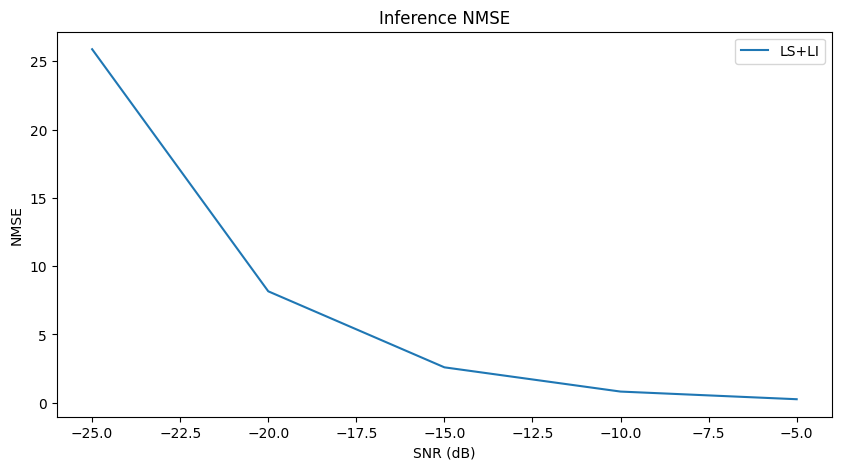

In [28]:
temp = []
for snr in SNR:
    mapBaseData_path = CDL_path + str(snr) + 'dB/1_mapBaseData.mat'
    file = h5py.File(mapBaseData_path, 'r')
    file['H_data'].shape

    H_true = np.empty((0, 2, 612, 14)) # true channel
    H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
            
    H_true = np.concatenate((H_true, (np.array(file['H_data']))) , axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_linear = np.concatenate((H_linear, (np.array(file['H_linear_data']))), axis=0)
    
    H_true = torch.from_numpy(H_true)
    H_linear = torch.from_numpy(H_linear)
    
    H_true_complex = torch.complex(H_true[:,0,:,:], H_true[:,1,:,:])
    H_linear_complex = torch.complex(H_linear[:,0,:,:], H_linear[:,1,:,:])
    
    nmse_snr_i = utils.calNMSE(H_linear_complex, H_true_complex) # size=32 (batch_size)
    temp.append(nmse_snr_i.cpu().mean())
    
plt.figure(figsize=(10, 5))
plt.plot(SNR, temp, label = 'LS+LI')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Inference NMSE')
plt.legend()
plt.show()